## A) Import libs

In [1]:
#import libs
import numpy as np 
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt 
import math
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import ipywidgets as widgets
from ipywidgets import interact

# import files 
from DataSet import DataSet
from DataGen import DataGen 
from FixedGP import FixedGP 
from DataGen import DataGen
from utilities import standardize_vector, map_plot, labeled_inputs_plot, compare_output_label, plot_combinations
#from MapUpdateNetwork import MapUpdateNetwork

c:\Users\deleu\OneDrive\Bureau\sciNeurotech\python\dataGEN\DataGen.py:334: SyntaxWarning: invalid escape sequence '\('
  """Prepare inputs and labels for Gaussian Process training.


## B) Load data from pth file

In [2]:
name = 'test_5que_10kcomb'

In [3]:
# Load the saved data from a .pth file using PyTorch
loaded_data = torch.load('dataset/og_'+name+'.pth', weights_only=True)  
# The 'weights_only=True' argument ensures that only the model weights (not the entire model) are loaded

# Access the tensors and the description from the loaded data
train_input = loaded_data["train_input"]  # The input data for training
train_label = loaded_data["train_label"]  # The corresponding labels for the training data
loaded_description = loaded_data["description"]  # The description or metadata associated with the data

print(loaded_description)

These labeled inputs have the original form.
These labeled inputs were made with these parameters:
 name: test_5que_10kcomb
 nb_queries: 5
 nb_comb: 10000
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]


### Visualize the labeled data 

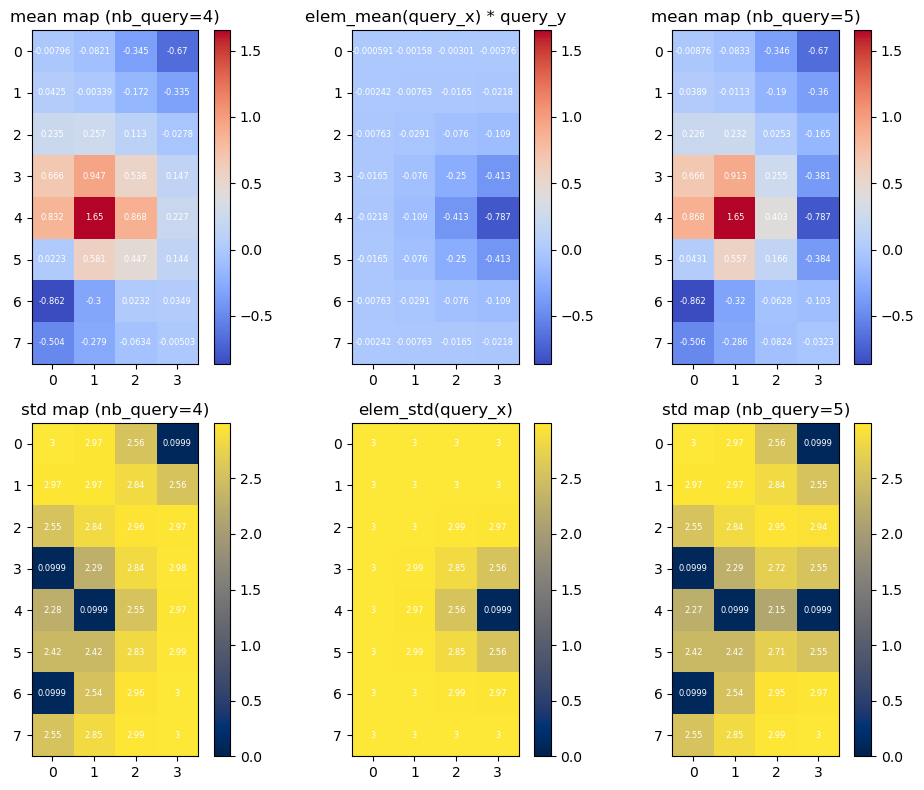

In [4]:
labeled_inputs_plot(train_input=train_input, train_label=train_label, comb_idx=0, values=True)

## C) Build NN model

In [5]:
class MapUpdateNetwork_1(nn.Module):
    """
    A convolutional neural network designed for processing and updating map-like structures.
    The network takes four input images as input, encodes their features, and decodes them 
    to generate an output map of the same spatial dimensions as the inputs.

    Attributes:
        encoder (nn.Sequential): Encoder that reduces spatial dimensions and extracts high-level features.
        decoder (nn.Sequential): Decoder that reconstructs the spatial dimensions from encoded features.

    Methods:
        __init__(in_channels, out_channels, out_channels_first_conv):
            Initializes the network with configurable input/output channels and feature depth.
        forward(img1, img2, img3, img4):
            Performs the forward pass by concatenating the input images, encoding their features, 
            and decoding them to produce the final map.
    """

    def __init__(self, in_channels=4, out_channels=2, out_channels_first_conv=16):
        """
        Initializes the MapUpdateNetwork.

        Args:
            in_channels (int): Number of input channels. Defaults to 4 (for concatenated input images).
            out_channels (int): Number of output channels. Defaults to 2.
            out_channels_first_conv (int): Number of channels in the first convolutional layer. Defaults to 16.
        """
        super(MapUpdateNetwork_1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 4 x 8x4 => 16 x 8x4
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=2, padding=1), # 16 x 8x4 => 32 x 4x2
            nn.ReLU(),
            nn.Conv2d(2*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 32 x 4x2 => 64 x 4x2
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4*out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 64 x 4x2 => 32 x 4x2
            nn.ReLU(),
            nn.ConvTranspose2d(2*out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1), # 32 x 4x2 => 16 x 8x4
            nn.ReLU()
        )
        self.final_layer1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1) # 16 x 8x4 => 1 x 8x4
        self.final_layer2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1), # 16 x 8x4 => 1 x 8x4
            nn.Sigmoid()
        )

    def forward(self, img1, img2, img3, img4):
        """
        Forward pass of the network. Combines four input images, processes them through
        an encoder-decoder architecture, and outputs an updated map.

        Args:
            img1 (torch.Tensor): First input image tensor of shape (B, C, H, W).
            img2 (torch.Tensor): Second input image tensor of shape (B, C, H, W).
            img3 (torch.Tensor): Third input image tensor of shape (B, C, H, W).
            img4 (torch.Tensor): Fourth input image tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Output map tensor of shape (B, out_channels, H, W), where 
                          H and W are the height and width of the input images.
        """
        x = torch.cat((img1, img2, img3, img4), dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        channel1 = self.final_layer1(x)  # Output non contraint
        channel2 = 3 * self.final_layer2(x)  # Contraint entre [0, 3]
        return torch.cat((channel1, channel2), dim=1)

In [6]:
class MapUpdateNetwork_2(nn.Module):
    def __init__(self, in_channels=4, out_channels_first_conv=16):
        super(MapUpdateNetwork_2, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 4 x 8x4 => 16 x 8x4
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=2, padding=1), # 16 x 8x4 => 32 x 4x2
            nn.ReLU(),
            nn.Conv2d(2*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 32 x 4x2 => 64 x 4x2
            nn.ReLU()
        )
        
        # Decoder for 2 outputs 
        self.decoder_shared = nn.ConvTranspose2d(4*out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1) # 64 x 4x2 => 16 x 8x2
        self.decoder_output1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1) # 16 x 8x4 => 1 x 8x4
        self.decoder_output2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1), # 16 x 8x4 => 1 x 8x4
            nn.Sigmoid()  # Normalisation [0, 1]
        )

    def forward(self, img1, img2, img3, img4):
        x = torch.cat((img1, img2, img3, img4), dim=1)
        x = self.encoder(x)
        x = self.decoder_shared(x)
        
        # 2 different outputs 
        output1 = self.decoder_output1(x)  
        output2 = self.decoder_output2(x) * 3  # Rescale pour [0, 3]
        
        return torch.cat((output1, output2), dim=1)


In [26]:
class MapUpdateNetwork_3(nn.Module):
    def __init__(self, in_channels=4, out_channels_first_conv=16):
        super(MapUpdateNetwork_3, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 4 x 8x4 => 16 x 8x4
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=2, padding=1), # 16 x 8x4 => 32 x 4x2
            nn.ReLU(),
            nn.Conv2d(2*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 32 x 4x2 => 64 x 4x2
            nn.ReLU()
        )
        
        # Decoder for 2 outputs 
        self.decoder_shared = nn.Sequential(
            nn.ConvTranspose2d(4*out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1), # 64 x 4x2 => 16 x 8x2
            nn.ReLU()
        )
        self.decoder_output1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1) # 16 x 8x4 => 1 x 8x4
        self.decoder_output2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1), # 16 x 8x4 => 1 x 8x4
            nn.Sigmoid()  # Normalisation [0, 1]
        )

        self.train_losses = []
        self.validation_losses = []

    def forward(self, img1, img2, img3, img4):
        x = torch.cat((img1, img2, img3, img4), dim=1)
        x = self.encoder(x)
        x = self.decoder_shared(x)
        
        # 2 different outputs 
        output1 = self.decoder_output1(x)  
        output2 = self.decoder_output2(x) * 3  # Rescale pour [0, 3]
        
        return torch.cat((output1, output2), dim=1)

## D) Training settings

In [8]:
train_X = train_input[:7000]
train_Y = train_label[:7000]

validation_X = train_input[7000:8500]
validation_Y = train_label[7000:8500]

test_X = train_input[8500:]
test_Y = train_label[8500:]

In [9]:
# Assuming train_X, train_Y, validation_X, validation_Y, test_X, test_Y are provided
batch_size = 32  # Batch size for DataLoader

# Create datasets and data loaders
train_dataset = TensorDataset(train_X, train_Y)
validation_dataset = TensorDataset(validation_X, validation_Y)
test_dataset = TensorDataset(test_X, test_Y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion1 = nn.MSELoss()
criterion2 = nn.MSELoss()  # Si les valeurs dans [0, 3] représentent des classes discrètes

def custom_loss(output, targets):
    target1 = targets[:, 0]  # Extraire les cibles pour le premier canal
    target2 = targets[:, 1]  # Extraire les cibles pour le deuxième canal
    loss1 = criterion1(output[:, 0], target1)
    loss2 = criterion2(output[:, 1], target2) 
    return loss1 + loss2

In [10]:
"""
# Initialize model, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MapUpdateNetwork()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
"""

'\n# Initialize model, loss function, and optimizer\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\nmodel = MapUpdateNetwork()\n\noptimizer = optim.Adam(model.parameters(), lr=1e-3)\n'

In [27]:
# Define training function
def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=20, device="cpu"):
    """
    Trains the given model using the provided data loaders.

    Args:
        model (nn.Module): The neural network to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        validation_loader (DataLoader): DataLoader for the validation dataset.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        num_epochs (int): Number of epochs to train. Default is 20.
        device (str): Device to use ('cpu' or 'cuda'). Default is 'cpu'.

    Returns:
        model (nn.Module): Trained model.
    """

    model.to(device)
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(*torch.split(inputs, 1, dim=1))  # Split into 4 inputs
            loss = custom_loss(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(*torch.split(inputs, 1, dim=1))
                loss = custom_loss(outputs, targets)
                validation_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {train_loss / len(train_loader):.10f}, "
              f"Validation Loss: {validation_loss / len(validation_loader):.10f}")
        
        model.train_losses.append(train_loss / len(train_loader))
        model.validation_losses.append(validation_loss / len(validation_loader))

    return model

In [12]:
# Define evaluation function
def evaluate_model(model, test_loader, criterion, device="cpu"):
    """
    Evaluates the trained model on a test dataset.

    Args:
        model (nn.Module): Trained neural network.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (nn.Module): Loss function.
        device (str): Device to use ('cpu' or 'cuda'). Default is 'cpu'.

    Returns:
        float: Average loss on the test set.
    """
    model.eval()
    model.to(device)
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(*torch.split(inputs, 1, dim=1))
            loss = custom_loss(outputs, targets)
            test_loss += loss.item()
    return test_loss / len(test_loader)

## E) Training 

In [ ]:
# Initialize model, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model_1 = MapUpdateNetwork_1()
optimizer = optim.Adam(model_1.parameters(), lr=1e-3)

Epoch [1/10] - Train Loss: 0.9885793189, Validation Loss: 0.5545120759
Epoch [2/10] - Train Loss: 0.2872454732, Validation Loss: 0.1359385453
Epoch [3/10] - Train Loss: 0.0998479937, Validation Loss: 0.0726167385
Epoch [4/10] - Train Loss: 0.0599059065, Validation Loss: 0.0422381748
Epoch [5/10] - Train Loss: 0.0372827747, Validation Loss: 0.0312708405
Epoch [6/10] - Train Loss: 0.0295561881, Validation Loss: 0.0248552565
Epoch [7/10] - Train Loss: 0.0242325669, Validation Loss: 0.0215960667
Epoch [8/10] - Train Loss: 0.0211434144, Validation Loss: 0.0188760609
Epoch [9/10] - Train Loss: 0.0190271750, Validation Loss: 0.0175067272
Epoch [10/10] - Train Loss: 0.0168944832, Validation Loss: 0.0163978198
Test Loss: 0.0168


In [22]:
# Train the model
num_epochs = 10
trained_model_1 = train_model(model_1, train_loader, validation_loader, custom_loss, optimizer, num_epochs, device)


# Evaluate the model on the test set
test_loss_1 = evaluate_model(trained_model_1, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss_1:.4f}")

Epoch [1/10] - Train Loss: 0.0166929947, Validation Loss: 0.0163978198
Epoch [2/10] - Train Loss: 0.0166979539, Validation Loss: 0.0163978198
Epoch [3/10] - Train Loss: 0.0166992416, Validation Loss: 0.0163978198
Epoch [4/10] - Train Loss: 0.0166972045, Validation Loss: 0.0163978198
Epoch [5/10] - Train Loss: 0.0166942604, Validation Loss: 0.0163978198
Epoch [6/10] - Train Loss: 0.0166972266, Validation Loss: 0.0163978198
Epoch [7/10] - Train Loss: 0.0166971034, Validation Loss: 0.0163978198
Epoch [8/10] - Train Loss: 0.0166950877, Validation Loss: 0.0163978198
Epoch [9/10] - Train Loss: 0.0166985819, Validation Loss: 0.0163978198
Epoch [10/10] - Train Loss: 0.0166986148, Validation Loss: 0.0163978198
Test Loss: 0.0168


In [ ]:
# Initialize model, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model_2 = MapUpdateNetwork_2()
optimizer = optim.Adam(model_2.parameters(), lr=1e-3)

Epoch [1/10] - Train Loss: 0.6724758005, Validation Loss: 0.1298906637
Epoch [2/10] - Train Loss: 0.0814988627, Validation Loss: 0.0502466583
Epoch [3/10] - Train Loss: 0.0406089442, Validation Loss: 0.0330723649
Epoch [4/10] - Train Loss: 0.0295801326, Validation Loss: 0.0264609183
Epoch [5/10] - Train Loss: 0.0247830059, Validation Loss: 0.0207844685
Epoch [6/10] - Train Loss: 0.0210715914, Validation Loss: 0.0184689181
Epoch [7/10] - Train Loss: 0.0188092691, Validation Loss: 0.0167014108
Epoch [8/10] - Train Loss: 0.0170412295, Validation Loss: 0.0150814537
Epoch [9/10] - Train Loss: 0.0155227841, Validation Loss: 0.0146204669
Epoch [10/10] - Train Loss: 0.0147021341, Validation Loss: 0.0150829770
Test Loss: 0.0157


In [23]:
# Train the model
num_epochs = 10
trained_model_2 = train_model(model_2, train_loader, validation_loader, custom_loss, optimizer, num_epochs, device)


# Evaluate the model on the test set
test_loss_2 = evaluate_model(trained_model_2, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss_2:.4f}")

Epoch [1/10] - Train Loss: 0.0155010843, Validation Loss: 0.0150829770
Epoch [2/10] - Train Loss: 0.0155027721, Validation Loss: 0.0150829770
Epoch [3/10] - Train Loss: 0.0155010611, Validation Loss: 0.0150829770
Epoch [4/10] - Train Loss: 0.0155023129, Validation Loss: 0.0150829770
Epoch [5/10] - Train Loss: 0.0154997427, Validation Loss: 0.0150829770
Epoch [6/10] - Train Loss: 0.0155037297, Validation Loss: 0.0150829770
Epoch [7/10] - Train Loss: 0.0155018020, Validation Loss: 0.0150829770
Epoch [8/10] - Train Loss: 0.0155034381, Validation Loss: 0.0150829770
Epoch [9/10] - Train Loss: 0.0155012327, Validation Loss: 0.0150829770
Epoch [10/10] - Train Loss: 0.0155026216, Validation Loss: 0.0150829770
Test Loss: 0.0157


In [28]:
# Initialize model, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model_3 = MapUpdateNetwork_3()
optimizer = optim.Adam(model_3.parameters(), lr=1e-3)

In [1]:
# Train the model
num_epochs = 40
trained_model_3 = train_model(model_3, train_loader, validation_loader, custom_loss, optimizer, num_epochs, device)


# Evaluate the model on the test set
test_loss_3 = evaluate_model(trained_model_3, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss_3:.4f}")

NameError: name 'train_model' is not defined

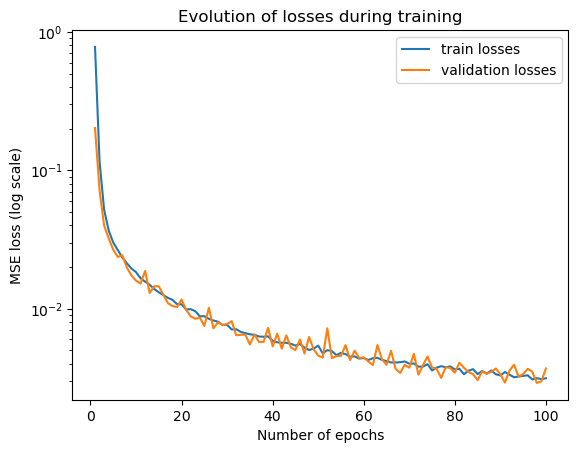

In [57]:
plt.plot(np.arange(len(trained_model_3.train_losses))+1, trained_model_3.train_losses, label='train losses')
plt.plot(np.arange(len(trained_model_3.validation_losses))+1, trained_model_3.validation_losses, label='validation losses')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss (log scale)')
plt.yscale('log')
plt.title("Evolution of losses during training")
plt.show()

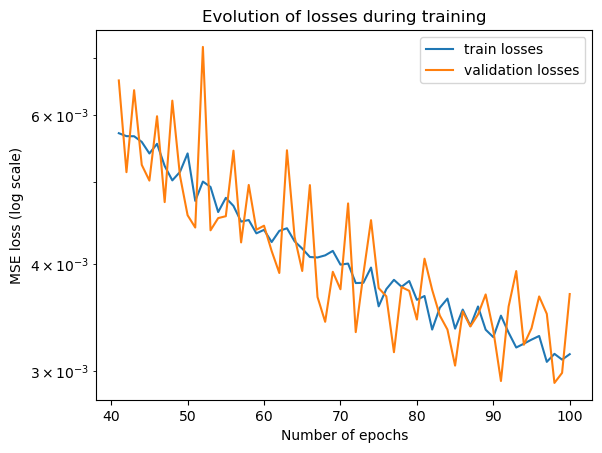

In [63]:
plt.plot(np.arange(len(trained_model_3.train_losses[40:]))+41, trained_model_3.train_losses[40:], label='train losses')
plt.plot(np.arange(len(trained_model_3.validation_losses[40:]))+41, trained_model_3.validation_losses[40:], label='validation losses')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss (log scale)')
plt.yscale('log')
plt.title("Evolution of losses during training")
plt.show()

## F) RESULTS

In [58]:

# Evaluate the model on the test set
test_loss = evaluate_model(trained_model_3, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss:.6f}")


Test Loss: 0.003740


## G) Postprocess

In [59]:
outputs = trained_model_3(*torch.split(test_X[0:10], 1, dim=1))

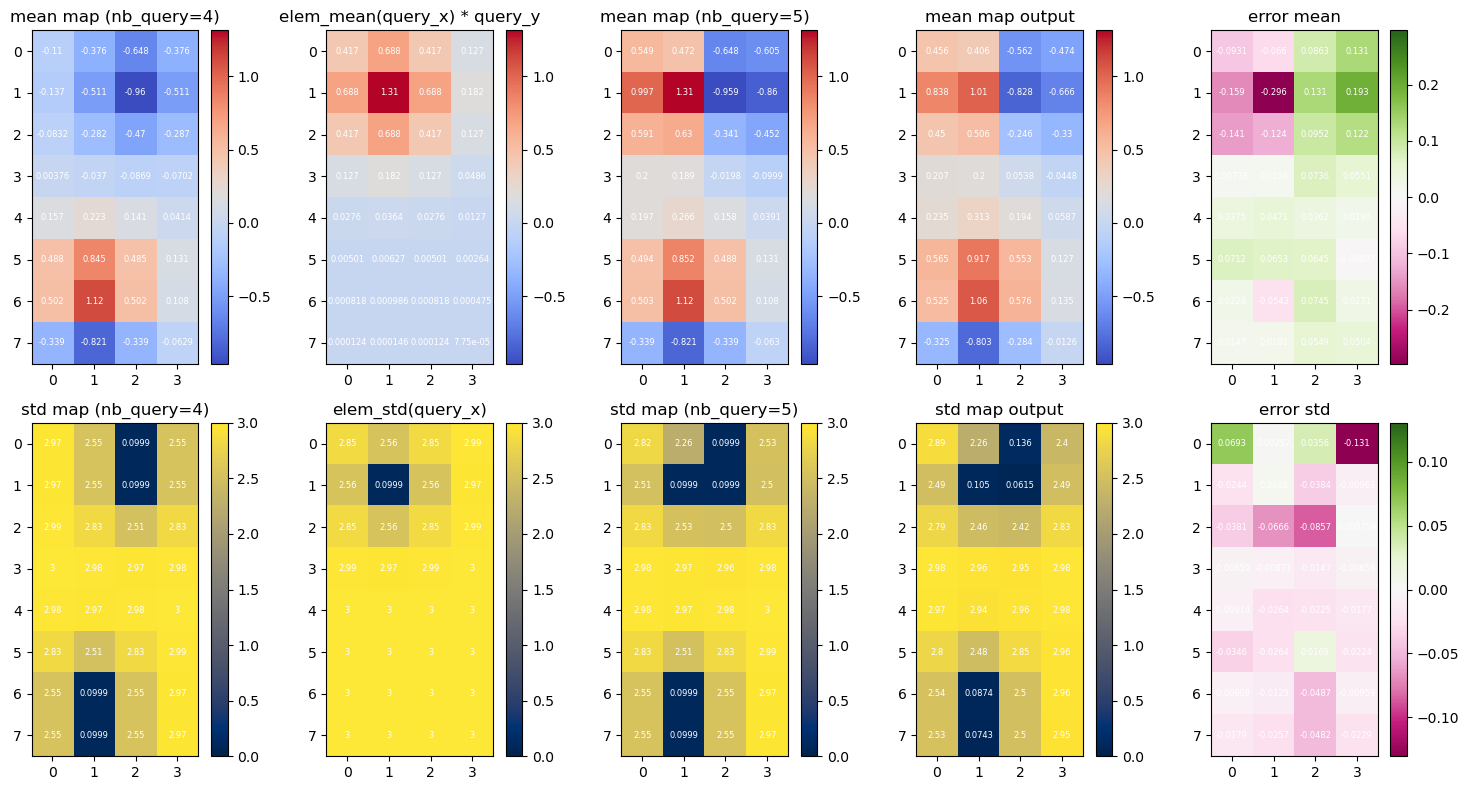

In [60]:
compare_output_label(train_input=test_X, train_label=test_Y, output=outputs.detach(), comb_idx=0, values=True)

In [61]:
plot_combinations(train_input=test_X, train_label=test_Y, output=outputs.detach(), comb_idx_range=(0, 9), values=True)

interactive(children=(IntSlider(value=0, description='Comb Index', max=9), Output()), _dom_classes=('widget-in…